# Setup

### Import Libraries

In [265]:
import cv2
import numpy as np
from functools import reduce

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks

# this allows you to control figure size
import pylab
pylab.rcParams['figure.figsize'] = (14.0, 6.0)

### Constants

In [266]:
IMAGE_PATH = 'data/duca.png'
N_CLUSTERS = 3

## Image preparation

We start by loading the image and enhancing the saturation, given that our work is based on the different colors of the field

In [267]:
# Get the image and convert it to HSV
image = cv2.imread(IMAGE_PATH)
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Increase the saturation (S channel)
h, s, v = cv2.split(hsv)
s = cv2.multiply(s, 2)  # by 50%
s = np.clip(s, 0, 255).astype(np.uint8)

# Merge back and convert to RGB
enhanced = cv2.merge([h, s, v])
image_rgb = cv2.cvtColor(enhanced, cv2.COLOR_HSV2RGB)

Display the images

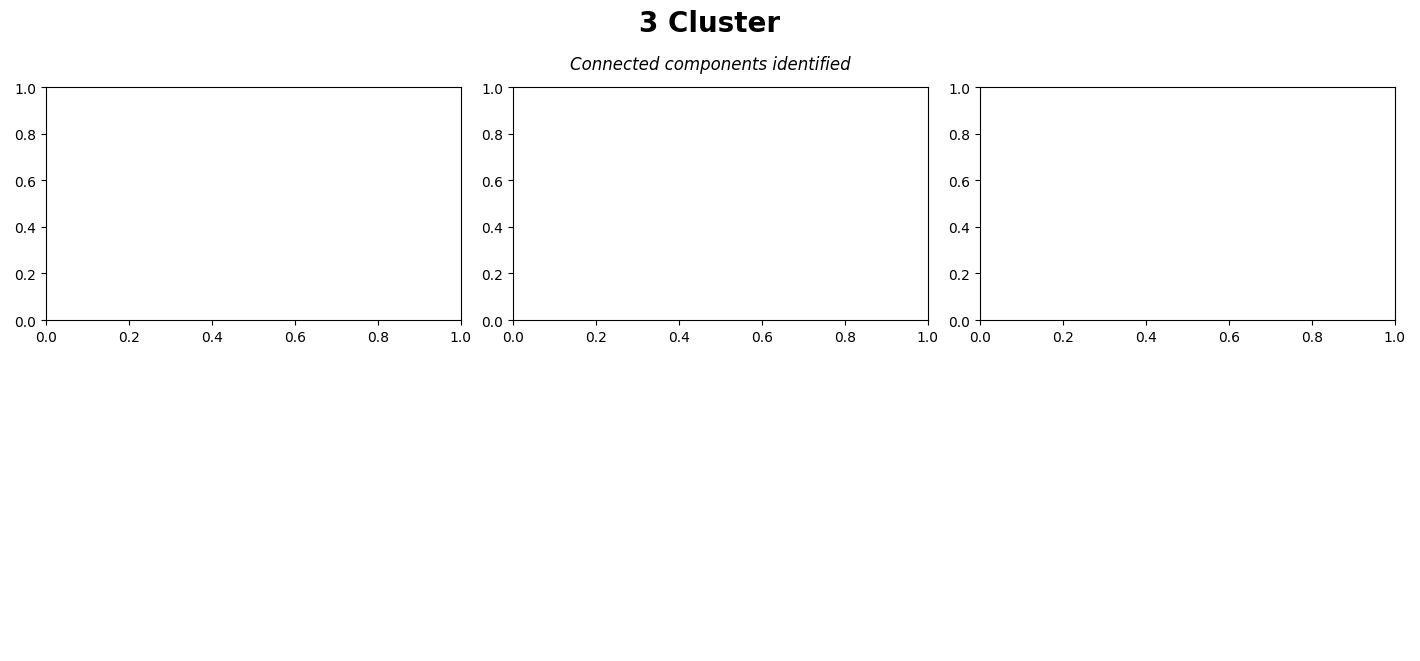

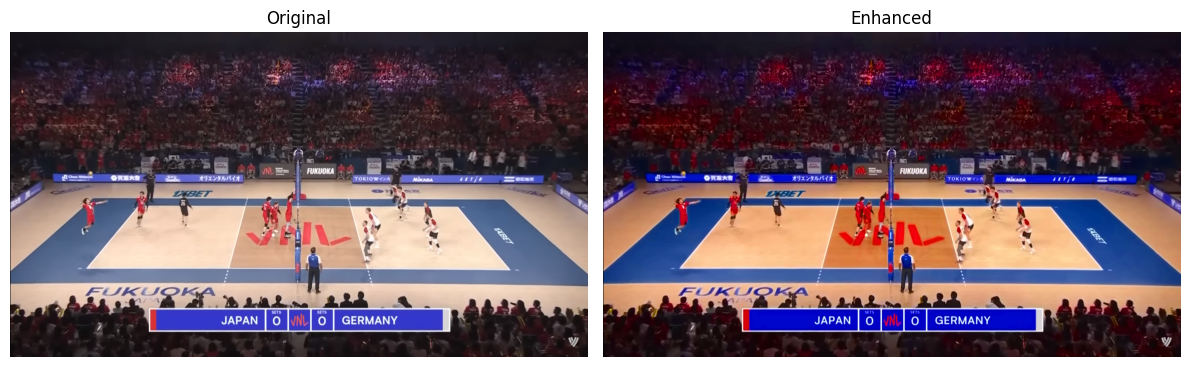

In [268]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original_rgb
axes[0].imshow(original_rgb)
axes[0].set_title('Original')
axes[0].axis('off')

# Display image_rgb
axes[1].imshow(image_rgb)
axes[1].set_title('Enhanced')
axes[1].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

# Field recognition

As a beginning, in this chapter we're recognizing the volleyball field in the given image.
In order to do so, we have to elaborate the court based on the colours contained in it. As a reference, we're using courts from official matches.

## K\-means

Then, we apply the K-means segmentation to divide the court

In [269]:
# flatten the dimensions of the image
# [height, width, 3 (channels RGB)] -> [height * width, 3]
pixels = image_rgb.reshape((-1, 3)).astype(np.float32)

# we define the stop criteria of the K-means:
# either at 100 max iteration or when the 1.0 (epsilon) accuracy is reached
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1.0)

# Applying the actual K-means with 3 clusters
# None initial clusters' names, 10 attempts with different initial centers
_, labels, _ = cv2.kmeans(pixels, N_CLUSTERS, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# The previous method returns which pixel belongs to which cluster eg. 0, 1 and 2
# We reshape the image back to its original format
labels_map = labels.reshape(image_rgb.shape[:2])

The result is the following

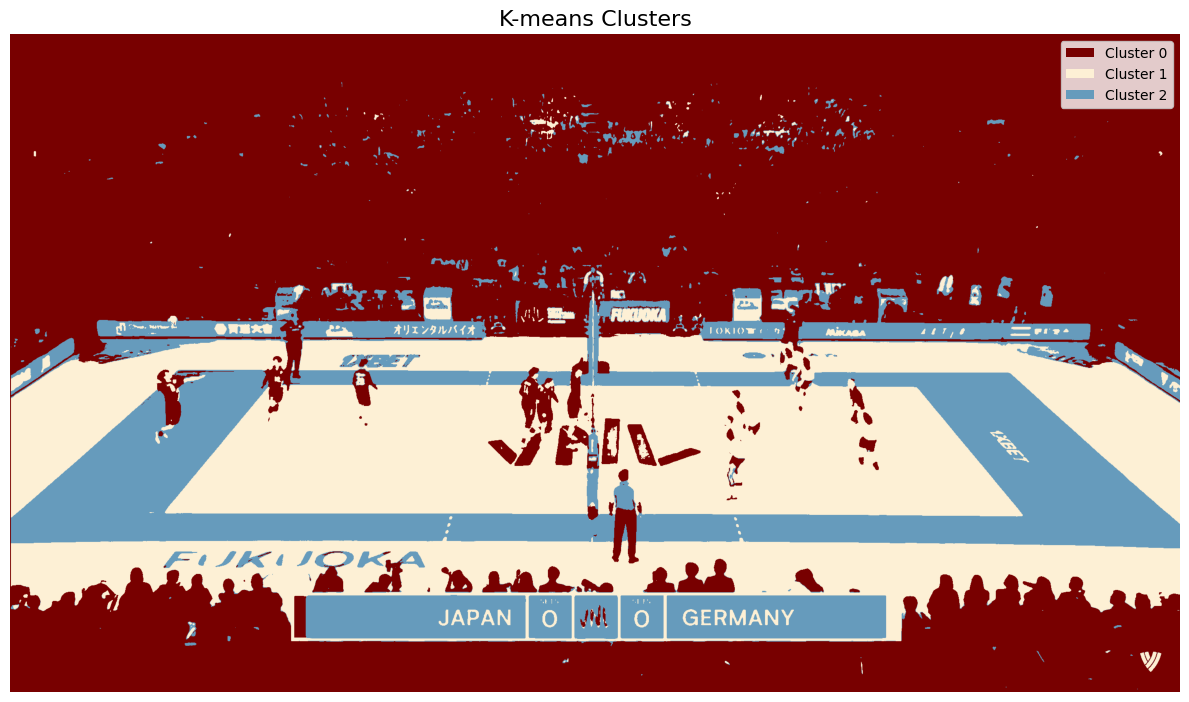

In [270]:
# Create a colored image showing all clusters
colored_clusters = np.zeros((labels_map.shape[0], labels_map.shape[1], 3), dtype=np.uint8)

# Define colors for each cluster (RGB format)
colors = [
    [120, 0, 0],    # Red for Cluster 0
    [253, 240, 213],    # Green for Cluster 1
    [102, 155, 188]     # Blue for Cluster 2
]

# Apply colors to each cluster
for i in range(N_CLUSTERS):
    mask = labels_map == i
    colored_clusters[mask] = colors[i]

# Create the plot with legend
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(colored_clusters)
ax.set_title('K-means Clusters', fontsize=16)
ax.axis('off')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=np.array(colors[i])/255.0, label=f'Cluster {i}') 
                   for i in range(N_CLUSTERS)]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Connected Components

### Utils

Visualization options

In [271]:
plt.ioff()

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(14, 6))
fig.suptitle(f'{N_CLUSTERS} Cluster', fontweight='bold', size=20, y=1.07)  

for ax in axs:
  ax.remove()
  
# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

subfigs[0].suptitle('Connected components identified', fontstyle='italic')
axs = subfigs[0].subplots(1, N_CLUSTERS)

plt.ion()

These functions will be used in code that follow them.

In [272]:
def apply_hough(image):
    """
    Apply Hough line detection, twice, and morphological operations to detect and enhance lines.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input binary image (grayscale) for line detection
        
    Returns:
    --------
    numpy.ndarray
        Binary image with detected lines enhanced using morphological closing
        
    Description:
    ------------
    This function performs the following steps:
    1. Detects lines using Hough Line Transform
    2. Draws detected lines on a blank image
    3. Applies morphological closing to connect nearby line segments
    """
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=200)
    h, w = image.shape
    lines_img = np.zeros((h, w, 3), dtype=np.uint8)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

    gray = cv2.cvtColor(lines_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closed


def fill_contours(mask, contours):
    """
    Fill contours by connecting border points and applying Hough line detection.

    Parameters:
    -----------
    mask : numpy.ndarray
        Input binary mask
    contours : list
        List of contours detected by cv2.findContours
        
    Returns:
    --------
    numpy.ndarray
        Binary mask with filled contours
        
    Description:
    ------------
    This function performs contour filling by:
    1. Drawing contour outlines
    2. Connecting gaps on image borders (top, bottom, left, right)
    3. Applying Hough line detection twice for line enhancement
    4. Filling the resulting contours completely
    """
    contour_img = np.zeros_like(mask)
    cv2.drawContours(contour_img, contours, -1, 255, 1)

    h, w = contour_img.shape

    # Top and bottom borders
    for y in [0, h - 1]:
        row = contour_img[y, :]
        on_indices = np.where(row > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                x1, x2 = on_indices[i], on_indices[i + 1]
                if x2 - x1 > 1:
                    cv2.line(contour_img, (x1, y), (x2, y), 255, 1)

    # Left and right borders
    for x in [0, w - 1]:
        col = contour_img[:, x]
        on_indices = np.where(col > 0)[0]
        if len(on_indices) >= 2:
            for i in range(len(on_indices) - 1):
                y1, y2 = on_indices[i], on_indices[i + 1]
                if y2 - y1 > 1:
                    cv2.line(contour_img, (x, y1), (x, y2), 255, 1)
    

    closed = apply_hough(apply_hough(contour_img))

    # Fill contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
        
    return filled

### Field Search

We have the clusters of the image. So, we have to find the connected components of the clusters and elaborate them.

In detail, for each cluster we apply an horizontal gaussian blur and a treshold, in order to smooth the image and horizontal areas.
Then, we remove the remaining horizontal artifacts from the clusters.

Given a elaburated cluster, we search for the connected components, take the biggest one for each cluster and fill its holes, using its contour. 

In [273]:
filled_components = [] # we store the components in order to compare them later
components = []

# For each cluster, we need to find the largest connected component in it
# That is done by preelaborating the clusters eg. removing holes and artifacts
# and filling holes of the found clusters
for i in range(N_CLUSTERS):

  # Create binary image for each cluster
  mask = ((labels_map == i).astype(np.uint8)) * 255


  # Horizontal denoising (gaussian blur + treshold)
  blurred = cv2.GaussianBlur(mask, (151, 1), 0)
  _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY) # < 127 -> 0, otherwise 255


  # We remove short artifacts from the cluster, doing an horizontal check
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
  opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
  closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)


  # We then extract the largest connected component from the elaborated mask
  num_labels, labels_im = cv2.connectedComponents(closed)
  component_mask = np.zeros_like(closed)
  if num_labels > 1: # we take the component with the biggest area
    # Define an array of components' areas, by counting the occurrencies of the labels,
    # excluding the background.
    areas = np.bincount(labels_im.flatten())[1:]  
    max_label = np.argmax(areas) + 1 # having excluded the background, we have to shift back
    component_mask = (labels_im == max_label).astype(np.uint8) * 255

  # and then we add the component to the list
  components.append(component_mask)


  # We find the contours of the component, in order to ignore the holes that might be in it
  contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # and the we fill the contours of the component
  filled = fill_contours(component_mask, contours)
  filled_components.append(filled)

  axs[i].imshow(filled)
  axs[i].axis('off')

subfigs[1].suptitle('Parts removed from the above components', fontstyle='italic')
axs = subfigs[1].subplots(1, N_CLUSTERS)

Now that we have the biggest connected, and filled, component for each cluster - we compare them to find which one identifies the field.

In order to do that, we have to filter out clusters having holes (from other clusters) _eg. the court around the actual field, has the "field" hole in it_.
The hole recognition is done as follows:
from a cluster's filled component, we remove all the areas in the other clusters - so that a hole that might have been filled in the previous steps, can get recognized.

Then, a similarity metric, defined by us, is introduced, thanks to that we can filter out the holed clusters.

At the end, the component with the center of mass closest to the center of the image, redefined as the one at 2/3rds of the height (lower in the image), is chosen as the field.

In [274]:
# D: [0, 255] => [False, True]
components = list( map(lambda x: x > 0, components) )

# These variables will be used to compare the clusters
min_distance = float('inf')
final_mask = None

# We need the center of the image in order to understand which cluster contains the field. 
# Since the field is always is usually located a little lower due to the camera's point of view, 
# we consider the “checking” center to be slightly lower than its actual position.
W = image_rgb.shape[1]
H = image_rgb.shape[0]
CENTER = (W // 2, 2 * H // 3)

# Choose the connected component that 
# a) has no holes in the middle
# b) is closest to the center of the image
for i in range(N_CLUSTERS):
  filled = filled_components[i]
  
  # We need to remove from the component under analysis
  # the areas of the other clusters, to then ensure there are no holes
  
  # We will apply the following truth table with the other masks
  # A and not B
  #   where A is the filled connected component under analysis
  #   and B is a generic area of another cluster
  # in our case, the possible B values are united (OR of the masks) 
  # and removed all together from A
  
  other_masks = components.copy()
  del other_masks[i]
  # In this mask we add everything that is present in the other clusters
  to_remove = reduce(lambda x, y: x | y, other_masks)

  # Apply the truth table A and not B and then convert back to the domain [0, 255]
  mask = ( filled & (~to_remove) ) * 255

  # 100% - whites_removed / total_whites (differences)      
  similarity =  1 - np.sum(filled > mask) / np.sum(filled > 0)
  
  axs[i].imshow(to_remove)
  axs[i].axis('off')
  axs[i].text(0.5, -0.1, f'Similarity: {int(similarity * 1000) / 10}%',
    transform=axs[i].transAxes, ha='center', fontsize=12)
   
  # If a connected component doesn't have holes in it, given by other clusters
  # we choose the components which has the closest center of mass to the center
  # of the image with the height at 2/3rds 
  if similarity > 0.9:
    # Center of mass calculation
    M = cv2.moments(filled)
    if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])
      cy = int(M["m01"] / M["m00"])
      # Euclidean distance from the ideal center
      distance = np.linalg.norm(np.array([cx, cy]) - np.array([CENTER[0], CENTER[1]]))
      if distance < min_distance:
        min_distance = distance
        final_mask = filled

## Result Visualization

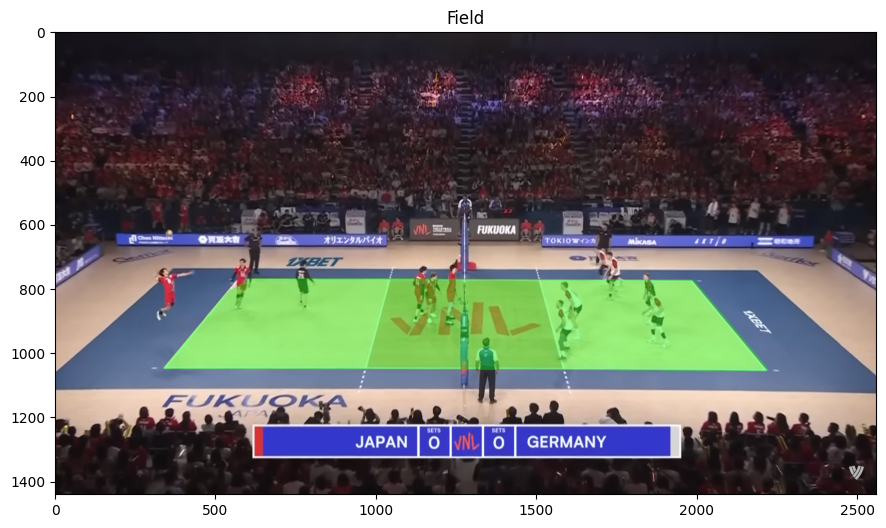

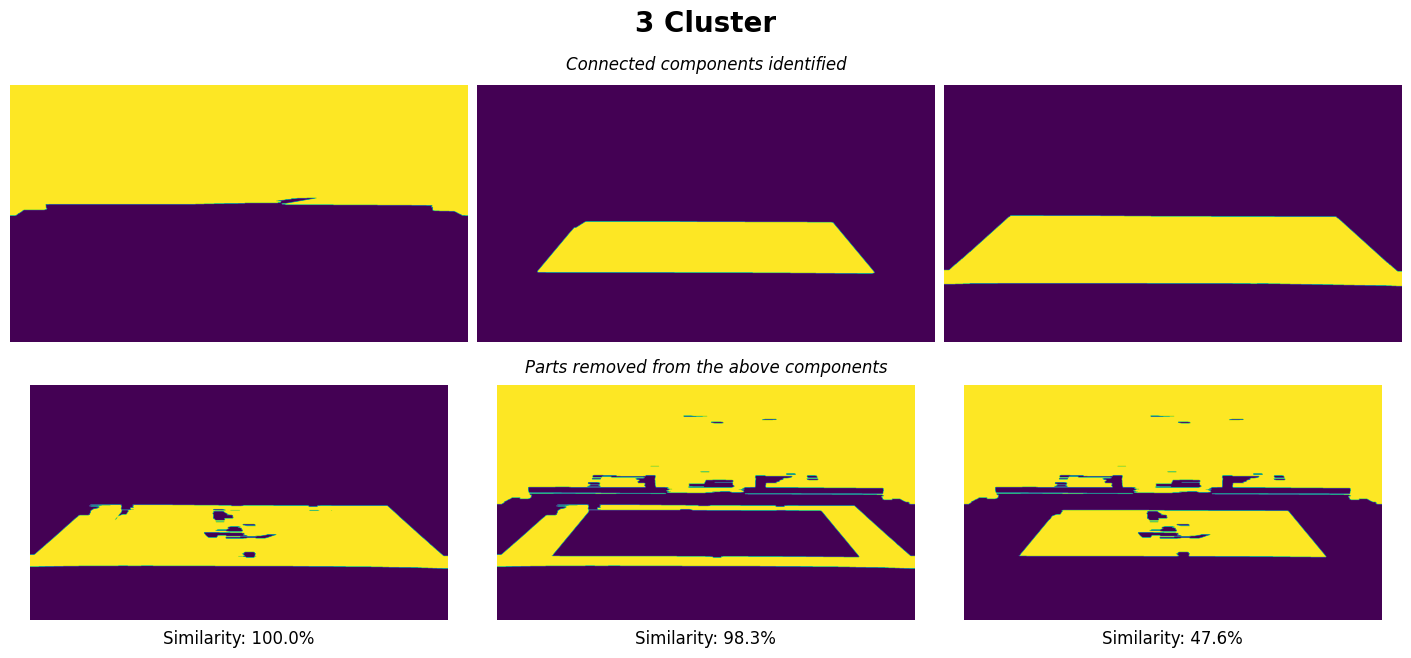

In [275]:
# green overlay
overlay = np.zeros_like(original_rgb, dtype=np.uint8)
overlay[:] = (0, 255, 0)  # Pure green

# Alpha blend
alpha = 0.4  # 0 = transparent, 1 = solid green
blended = cv2.addWeighted(original_rgb, 1 - alpha, overlay, alpha, 0)

output = np.where(final_mask[:, :, np.newaxis] == 255, blended, original_rgb)

res_fig, res_ax = plt.subplots(1, 1)
res_ax.imshow(output)
res_ax.set_title('Field')

figures = []
figures.append(fig)

figures.insert(0, res_fig)

for figure in figures:
  display(figure)
  plt.close(figure)

# Net Recognition

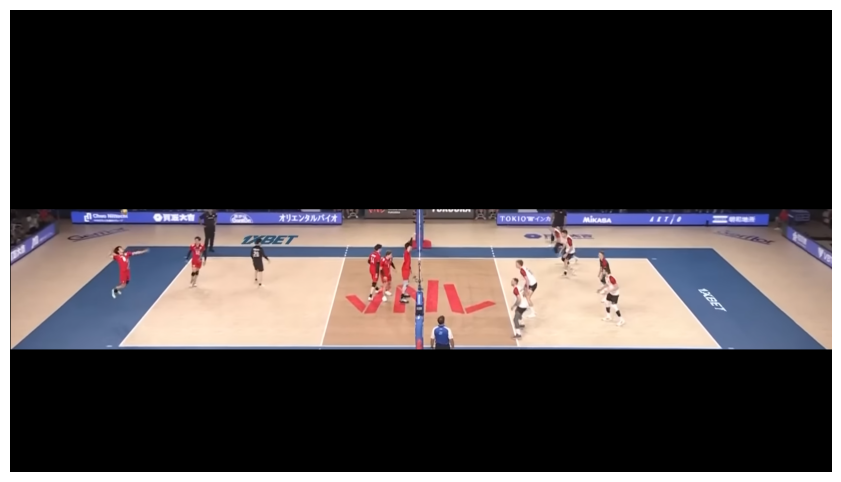

In [276]:
# Create a new empty mask
extended_mask = np.zeros_like(final_mask)
# Find the vertical bounds (y_min, y_max) of the region in final_mask
ys, xs = np.where(final_mask > 0)
if len(ys) > 0:
    y_min = ys.min()
    y_max = ys.max()
    h_region = y_max - y_min + 1
    # Calculate the new extended y_min upward by half the height
    new_y_min = max(0, int(y_min - h_region / 2))
    # Calculate the actual height to copy to avoid broadcasting errors
    src_height = y_max - y_min + 1
    dst_height = final_mask.shape[0] - new_y_min
    copy_height = min(src_height, dst_height)
    # Copy the original region to the new extended position
    extended_mask[new_y_min:y_min+copy_height, :] = 255
    # Update final_mask with the extended version

# Convert the mask to a color image
extended_mask = cv2.cvtColor(extended_mask, cv2.COLOR_GRAY2BGR)
# Apply the mask to the original image
masked_image = cv2.bitwise_and(original_rgb, extended_mask)
# Show the final image
plt.imshow(masked_image)
plt.axis('off')
plt.show()

[[1270  964]
 [1276  622]] 342.0526275297414


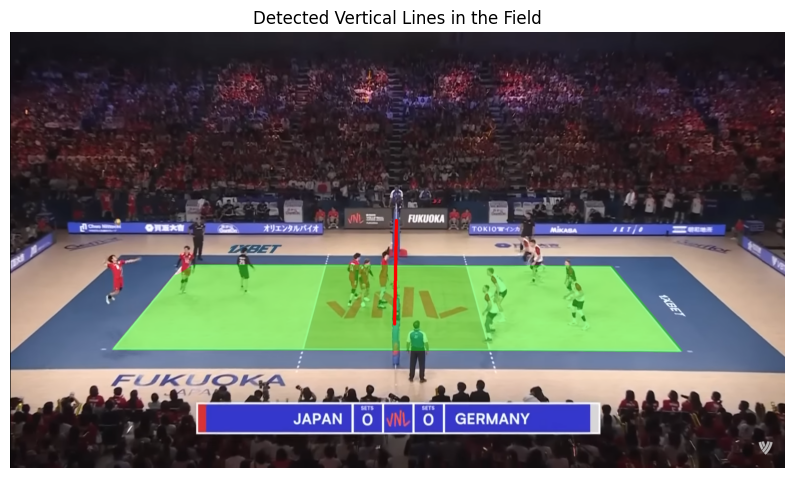

In [281]:
# Step 1: Preprocess the image
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)  # Convert the masked image to grayscale
edges = cv2.Canny(gray, 50, 150)  # Apply edge detection using the Canny algorithm

# Step 2: Detect vertical lines using Hough Line Transform
all_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=120, maxLineGap=1000)

# Create an empty image to draw the vertical lines
vertical_lines_img = np.zeros_like(edges)

# Step 3: Overlay the detected areas on the original masked image
overlay = output.copy()  # Create a copy of the original masked image for visualization

lines = []
W = image_rgb.shape[1]
# Filter and draw near-vertical lines
if all_lines is not None:
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        angle = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
        if 80 < angle < 100 and (x1 + x2) > 100 and (2 * W - (x1 + x2)) > 100:  # Filter near-vertical lines
            p1 = np.array([x1, y1])
            p2 = np.array([x2, y2])
            l = np.array([p1, p2])
            lines.append(l)

# Step 4: Compute lengths of the detected lines
def line_length(line):
    diffs = np.diff(line, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(segment_lengths)

lengths = [line_length(line) for line in lines]

# Step 5: Get the longest line
longest_index = np.argmax(lengths)
longest_line = lines[longest_index]
longest_length = lengths[longest_index]
print(longest_line, lengths[longest_index])
cv2.line(overlay, longest_line[0], longest_line[1], (255, 0, 0), 10)  # Draw the longest line on the overlay

# Step 6: Visualize the detected vertical lines
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title('Detected Vertical Lines in the Field')
plt.axis('off')
plt.show()


# Referee Area Recognition

Top pixel coordinates: [1276  622]


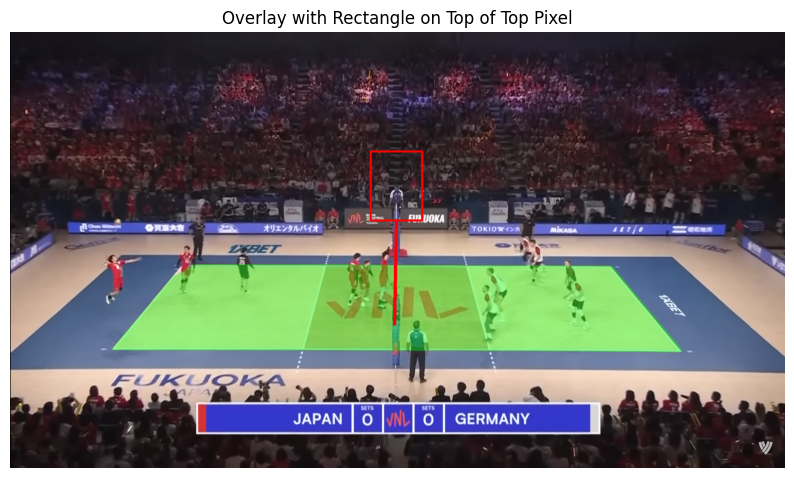

In [278]:
# Get the top pixel of the longest line
top_pixel = longest_line[0] if longest_line[0][1] < longest_line[1][1] else longest_line[1]
print(f"Top pixel coordinates: {top_pixel}")

# Define the size of the rectangle
rect_width = int(longest_length/2)  # Width of the rectangle
rect_height = int(longest_length/1.5)  # Height of the rectangle

# Calculate the top-left and bottom-right corners of the rectangle
final = overlay.copy()
top_left = (top_pixel[0] - rect_width // 2, top_pixel[1] - rect_height)
bottom_right = (top_pixel[0] + rect_width // 2, top_pixel[1])

# Draw the rectangle on the overlay
cv2.rectangle(final, top_left, bottom_right, (255, 0, 0), 5)  # Green rectangle with thickness 5

# Visualize the updated overlay
plt.figure(figsize=(10, 6))
plt.imshow(final)
plt.title('Overlay with Rectangle on Top of Top Pixel')
plt.axis('off')
plt.show()